# Stacking 
* LR with K fold CV 
* 26.2

.

`stacking 방법`
1. simple linear regression : 26.2
2. RFE (feature selection) : 26.2
3. lr without intercept : 27.3
4. nnls : 26.3, (절편 X : 26.6) 

In [3]:
import os
import sys
import glob
import joblib
import pickle as pkl

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')
warnings.filterwarnings(action='ignore', category=DataConversionWarning)


import pandas as pd 
import numpy as np


from IPython.display import display
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('display.max_info_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

In [4]:
# MAPE 
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Data Prep

### model pkl load

In [93]:
cd ../../FinalPred

[Errno 2] No such file or directory: '../../FinalPred'
/Users/jbeen/workdir/bigcontest/branch/FinalPred


In [95]:
pkls = glob.glob('*.pickle')
pkls

['lgbm_pred0923-lgbm-optuna2.pickle',
 'xgb_pred0923-xgb-bayes2.pickle',
 'lgbm_pred0921-lgbm-bayes2.pickle',
 'lgbm_pred0921-lgbm-optuna2.pickle',
 'pred_catBA_0924.pickle',
 'lgbm_pred0921-lgbm-bayes.pickle',
 'xgb_pred0923-xgb-bayes1.pickle',
 'lgbm_pred0921-lgbm-bayes3.pickle',
 'pred_rfBO_0924.pickle',
 'pred_rfOP_0924.pickle']

In [96]:
final = dict()
for p in pkls : 
    with open('{}'.format(p), 'rb') as f:
        final[p.split(".")[0]] = pkl.load(f)

In [97]:
# train index
final['lgbm_pred0921-lgbm-bayes2']['val_idx']

[array([    0,     2,    13, ..., 28273, 28282, 28290]),
 array([    1,     7,    15, ..., 28295, 28299, 28300]),
 array([    3,    10,    11, ..., 28287, 28289, 28297]),
 array([    4,    36,    43, ..., 28294, 28301, 28302]),
 array([    5,     6,     8, ..., 28293, 28296, 28298])]

In [98]:
# test index 
final['lgbm_pred0921-lgbm-bayes2']['test_idx']

[Int64Index([ 8734,  7885,  2413, 12475,  4571,  9835, 35907, 14833, 10316,
             31140,
             ...
             25556, 30587,  6430, 11575, 33365, 14158, 28909, 34363, 26499,
              4615],
            dtype='int64', length=7076)]

In [99]:
# test pred 
final['lgbm_pred0921-lgbm-bayes2']['final_pred']

[array([10557563.93721553, 18074929.25387817, 23836593.06907338, ...,
        29718194.91621904, 20162063.64308697, 11676675.72850286])]

### data load

In [100]:
data_v4 = joblib.load(os.path.join('..', '7th_train_FE.pkl'))
locals().update(data_v4)

In [101]:
X = data_v4['X'] ; y = data_v4['y']
X.shape, y.shape

((35379, 402), (35379,))

In [102]:
y2 = np.log1p(y)

## Meta Test 

In [103]:
X_test = X.loc[final['lgbm_pred0921-lgbm-bayes3']['test_idx'][0]]
y_test = y.loc[final['lgbm_pred0921-lgbm-bayes3']['test_idx'][0]]

In [104]:
X_test.shape, y_test.shape

((7076, 402), (7076,))

## Meta Train 
* K fold 하면서 reindex 가 되어 버려서 이렇게 나눠 줘야 함 ㅎㅎㅎ;;

In [66]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold

In [105]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.2, random_state=77)
X_train, y_train = dict(), dict() 

cv = KFold(n_splits=5, random_state=77, shuffle=True)

i = 0
for t,v in cv.split(X_train_):
    X_train['{}'.format(i+1)] = X_train_.iloc[v]
    y_train['{}'.format(i+1)] = y_train_.iloc[v]
    i+=1

## Final Stacking Dataset

### train

In [106]:
# train : y_true
y_train1, y_train2, y_train3, y_train4, y_train5 = y_train['1'], y_train['2'], y_train['3'], y_train['4'], y_train['5']

In [107]:
y_train1.shape, y_train2.shape, y_train3.shape, y_train4.shape, y_train5.shape

((5661,), (5661,), (5661,), (5660,), (5660,))

In [108]:
# train : y_pred
x_train1, x_train2, x_train3, x_train4, x_train5 = [], [], [], [], []
for model in list(final.keys()) : 
    x_train1.append(final[model]['val_pred'][0])
    x_train2.append(final[model]['val_pred'][1])
    x_train3.append(final[model]['val_pred'][2])
    x_train4.append(final[model]['val_pred'][3])
    x_train5.append(final[model]['val_pred'][4])

In [109]:
X_train1 = pd.DataFrame(np.array(x_train1).T)
X_train2 = pd.DataFrame(np.array(x_train2).T)
X_train3 = pd.DataFrame(np.array(x_train3).T)
X_train4 = pd.DataFrame(np.array(x_train4).T)
X_train5 = pd.DataFrame(np.array(x_train5).T)

In [110]:
X_train1.shape, X_train2.shape, X_train3.shape, X_train4.shape, X_train5.shape

((5661, 10), (5661, 10), (5661, 10), (5660, 10), (5660, 10))

In [111]:
# train : y_pred (fold1)
X_train1

,0,1,2,3,4,5,6,7,8,9
0,5216106.981,5002080.500,4823899.432,5351551.517,4943182.161,5009392.227,5051207.000,5371598.932,4546394.644,8425060.060
1,23286991.105,26903864.000,30710439.096,28684130.413,25404243.182,30201280.451,26913204.000,29496085.601,29706038.944,14841972.562
2,37809721.353,33207140.000,37052866.379,37636418.450,42199530.361,37347219.485,37938432.000,36089203.008,39472577.259,35946730.244
3,17648725.068,17634396.000,18142823.396,20864664.244,16748028.365,17666875.371,17802118.000,18779775.008,12935502.030,10189337.789
4,17998340.311,22854144.000,27179897.700,27788596.748,19550084.835,26988413.041,23045212.000,26630704.345,25185319.585,11944275.348
...,...,...,...,...,...,...,...,...,...,...
5656,9925871.884,12318332.000,12554725.674,12286967.730,13927865.058,11797670.484,13467663.000,12851236.801,13401661.995,13905817.805
5657,63262957.376,61173696.000,63719257.429,62255385.937,63260362.015,65273282.722,62261132.000,69049500.436,54786314.137,37530375.965
5658,14163588.168,13168789.000,12363481.319,12820084.773,14551293.495,12765532.361,12476642.000,12128576.670,11913303.958,10189337.789
5659,2599725.260,2687072.000,2603623.542,2600327.439,2675103.570,2665305.421,2816054.250,2634154.195,3634522.393,10189337.789


### test

In [112]:
# test : y_true 
y_test = y_test

In [113]:
# test : y_pred 
x_test = [] 
for model in list(final.keys()) : 
    x_test.append(final[model]['final_pred'][0])

In [114]:
X_test = pd.DataFrame(np.array(x_test).T)

In [115]:
X_test.columns = list(final.keys())
X_test

,lgbm_pred0923-lgbm-optuna2,xgb_pred0923-xgb-bayes2,lgbm_pred0921-lgbm-bayes2,lgbm_pred0921-lgbm-optuna2,pred_catBA_0924,lgbm_pred0921-lgbm-bayes,xgb_pred0923-xgb-bayes1,lgbm_pred0921-lgbm-bayes3,pred_rfBO_0924,pred_rfOP_0924
0,9591443.090,9584501.000,10557563.937,10780855.756,8720125.992,10768459.884,9327498.000,10598563.187,8049626.265,14327193.091
1,19477071.478,17422680.000,18074929.254,17872822.527,17079485.060,18417007.456,15580698.000,18538841.152,16065824.592,9911299.828
2,22319051.644,23809632.000,23836593.069,23295534.990,22081820.426,23582263.379,23184280.000,24345702.827,23355461.721,13258493.937
3,12426858.544,11590858.000,11458951.682,11437477.754,12987877.855,11731664.566,11058974.000,11069759.611,8280823.264,9911299.828
4,7990220.247,8769371.000,9124130.938,8847853.113,8878167.689,9043249.828,9409084.000,9047417.803,12246039.713,9911299.828
...,...,...,...,...,...,...,...,...,...,...
7071,24495410.870,22910232.000,23753803.570,23677343.603,24887054.768,23275574.621,23344796.000,23660596.038,18932783.267,14069410.792
7072,13153695.735,11775613.000,12579173.142,13792612.985,14124432.285,12468375.973,12031341.000,13078761.764,13230361.288,13844735.883
7073,30664490.831,33315082.000,29718194.916,33301323.031,35079776.403,33360258.457,34366056.000,34070041.050,38664423.304,16071199.894
7074,22603795.220,19340354.000,20162063.643,19219763.220,25955786.535,20694847.424,19071340.000,20866811.980,12717937.777,8697616.010


In [116]:
X_test.shape, y_test.shape

((7076, 10), (7076,))

## final_진짜진짜최종_(2) dataset

In [117]:
# train for stacking 
st_x_train = pd.concat([X_train1, X_train2, X_train3, X_train4, X_train5], axis=0) # 예측값 
st_y_train = pd.concat([y_train1, y_train2, y_train3, y_train4, y_train5], axis=0) # 실제값 

In [118]:
st_x_train.shape, st_y_train.shape

((28303, 10), (28303,))

In [119]:
# test for stacking 
st_x_test = X_test # 예측값 
st_y_test = y_test # 실제값 

In [120]:
st_x_test.shape, st_y_test.shape

((7076, 10), (7076,))

In [121]:
st_x_train.columns, st_x_test.columns  = list(final.keys()), list(final.keys())

# Stacking

## 1. simple linear regression 

In [86]:
from sklearn.linear_model import LinearRegression

In [122]:
lr = LinearRegression()

In [123]:
lr.fit(st_x_train, st_y_train)
train_pred = lr.predict(st_x_train)
lr.score(st_x_train, st_y_train)

0.8096739263172108

In [124]:
print(lr.coef_) # 추정된 회귀계수 (intercept제외)
print(lr.intercept_) # intercept

[ 0.13818165 -0.06730301 -0.22427983  0.11962145  0.63252811  0.31001254
  0.41688275 -0.17406694 -0.07665459 -0.07544467]
1151106.403360825


In [125]:
lr.score(st_x_test, st_y_test)

0.8441765654936013

### 최종 예측값의 MAPE ~!

In [126]:
MAPE(lr.predict(st_x_test), st_y_test)

26.237849479607352

In [127]:
lr.predict(st_x_test) # 최종 예측값 

array([ 9952919.78139105, 18555820.8300818 , 23988236.23728467, ...,
       37215431.06148589, 26270664.02365527, 12786290.80664591])

## 2. feature selection : 유의미한 모델만 결과에 넣기!
* from 캐글.. : https://www.kaggle.com/jnikhilsai/cross-validation-with-linear-regression
* RFE : Backward 방식중 하나로, 모든 변수를 우선 다 포함시킨 후 반복해서 학습을 진행하면서 중요도가 낮은 변수를 하나씩 제거하는 방식

In [128]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In [131]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 77)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 11))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(st_x_train, st_y_train)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(st_x_train, st_y_train)   

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=77, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10]}],
             return_train_score=True, scoring='r2', verbose=1)

In [132]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.025,0.003,0.002,0.000,1,{'n_features_to_select': 1},0.824,0.788,0.804,0.793,0.820,0.806,0.014,10,0.801,0.811,0.807,0.809,0.803,0.806,0.004
1,0.021,0.002,0.002,0.000,2,{'n_features_to_select': 2},0.825,0.788,0.806,0.795,0.821,0.807,0.014,9,0.803,0.812,0.808,0.811,0.804,0.808,0.004
2,0.018,0.002,0.002,0.000,3,{'n_features_to_select': 3},0.824,0.789,0.806,0.795,0.821,0.807,0.014,8,0.803,0.813,0.808,0.811,0.804,0.808,0.004
3,0.015,0.000,0.002,0.000,4,{'n_features_to_select': 4},0.824,0.789,0.807,0.795,0.821,0.807,0.014,7,0.803,0.813,0.808,0.811,0.805,0.808,0.004
4,0.014,0.000,0.002,0.000,5,{'n_features_to_select': 5},0.824,0.788,0.806,0.796,0.821,0.807,0.014,6,0.803,0.813,0.808,0.812,0.805,0.808,0.004
5,0.013,0.000,0.002,0.000,6,{'n_features_to_select': 6},0.825,0.788,0.807,0.796,0.821,0.808,0.014,5,0.804,0.813,0.809,0.812,0.805,0.809,0.004
6,0.011,0.000,0.002,0.000,7,{'n_features_to_select': 7},0.825,0.788,0.807,0.796,0.822,0.808,0.014,4,0.804,0.813,0.809,0.812,0.805,0.809,0.004
7,0.009,0.000,0.002,0.000,8,{'n_features_to_select': 8},0.825,0.789,0.807,0.796,0.823,0.808,0.014,3,0.804,0.814,0.809,0.812,0.806,0.809,0.004
8,0.008,0.000,0.002,0.000,9,{'n_features_to_select': 9},0.826,0.789,0.808,0.797,0.823,0.809,0.014,2,0.805,0.814,0.810,0.813,0.806,0.810,0.004
9,0.006,0.000,0.002,0.000,10,{'n_features_to_select': 10},0.827,0.790,0.808,0.797,0.823,0.809,0.014,1,0.805,0.815,0.810,0.813,0.806,0.810,0.004


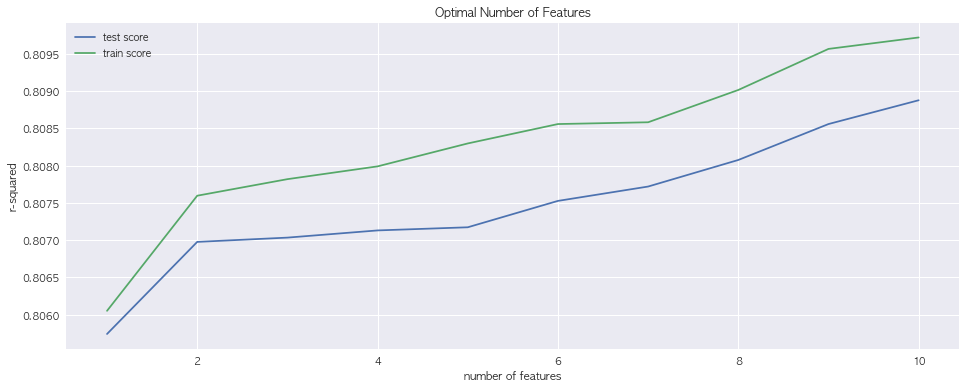

In [133]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [134]:
# final model
n_features_optimal = 10

lm = LinearRegression()
lm.fit(st_x_train, st_y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(st_x_train, st_y_train)

# predict prices of X_test
y_pred = lm.predict(st_x_test)
r2 = r2_score(st_y_test, y_pred)
print(r2)

0.8441765654936013


In [135]:
rfe.support_ # 'lgbm_pred0921-lgbm-optuna2.pickle', 'lgbm_pred0921-lgbm-bayes.pickle' 이거 두개 피쳐 썼다 

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [136]:
print(rfe.estimator_.coef_)

[ 0.13818165 -0.06730301 -0.22427983  0.11962145  0.63252811  0.31001254
  0.41688275 -0.17406694 -0.07665459 -0.07544467]


In [137]:
rfe.estimator_.intercept_

1151106.403360825

### 최종 MAPE값~!! 

In [138]:
MAPE(y_pred, y_test)

26.237849479607352

## 3. 절편 없는 linear regression 

In [139]:
lr2 = LinearRegression(fit_intercept=False)

In [140]:
lr2.fit(st_x_train, st_y_train)
train_pred = lr2.predict(st_x_train)
lr2.score(st_x_train, st_y_train)

0.8088884477690231

In [141]:
print(lr2.coef_) # 추정된 회귀계수 (intercept제외)
print(lr2.intercept_) # intercept

[ 0.15649294 -0.07364642 -0.21708059  0.10927126  0.62445588  0.30973601
  0.41039137 -0.16519291 -0.07647256 -0.02872141]
0.0


In [142]:
lr2.score(st_x_test, st_y_test)

0.8444428992061117

### 최종 MAPE

In [143]:
MAPE(lr2.predict(st_x_test), st_y_test)

27.371770436264075

In [144]:
lr2.predict(st_x_test)

array([ 9512082.48919697, 17982408.36893737, 23529785.40139205, ...,
       36828568.1496459 , 25611827.21440176, 12333546.60081367])

## 4. nnls 
* non-negative least square 
* 민정 앙상블 과제처럼, 모든 계수의 합이 positive가 되게끔 하는 방법 


* 공식 sklearn 패키지는 없고, 사용하려면 scipy.optimize.nnls 사용해야 하는데, 사용법이 굉장히 복잡해 보임.. 
* 따라서 이와 식이 상당히 유사한 `Lasso Regression(alpha=0, positive=True)` 를 써 보겠음! 

In [145]:
from sklearn.linear_model import Lasso

In [146]:
reg_nnls = Lasso(alpha=0, positive=True)

In [147]:
reg_nnls.fit(st_x_train, st_y_train)
train_pred = reg_nnls.predict(st_x_train)
reg_nnls.score(st_x_train, st_y_train)

0.8079930796060792

In [148]:
print(reg_nnls.coef_, reg_nnls.intercept_)

[0.16194853 0.         0.         0.00904134 0.65205739 0.11520242
 0.11474    0.         0.         0.        ] 327031.0731033534


In [149]:
reg_nnls.score(st_x_test, st_y_test)

0.8429240621222148

### 최종 MAPE

In [150]:
MAPE(reg_nnls.predict(st_x_test), st_y_test)

26.322258624889926

### without intercept

In [151]:
reg_nnls2 = Lasso(alpha=0, positive=True, fit_intercept=False)

In [152]:
reg_nnls2.fit(st_x_train, st_y_train)
train_pred = reg_nnls2.predict(st_x_train)
reg_nnls2.score(st_x_train, st_y_train)

0.8078766635056095

In [153]:
print(reg_nnls2.coef_, reg_nnls2.intercept_)

[0.12996957 0.         0.         0.00657519 0.67575647 0.13061537
 0.11847114 0.         0.         0.        ] 0.0


In [154]:
reg_nnls2.score(st_x_test, st_y_test)

0.8431941444345603

### 최종 MAPE

In [155]:
MAPE(reg_nnls2.predict(st_x_test), st_y_test)

26.612890351553652